In [1]:
%load_ext autoreload
%autoreload 2
import time
import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import SimpleITK as sitk
import pydicom
import nibabel as nib

from torch.utils.data import DataLoader

from src.data import NSCLCDataset
from utils import profile_load_time
from visualize import plot_samples

In [4]:
#train_ds = NSCLCDataset(subset='train')
val_ds = NSCLCDataset(subset='val')
len(val_ds)

Caching CT scans metadata: 100%|██████████| 81/81 [00:41<00:00,  1.94it/s]


10288

Iter: 100%|██████████| 2000/2000 [00:18<00:00, 106.25it/s]


total 18.59s, average 0.01s


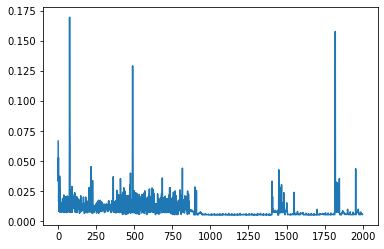

In [5]:
profile_load_time(val_ds, num_iters=2000)

Iter: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


total 83.57s, average 1.67s


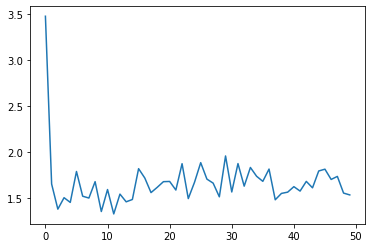

In [6]:
val_loader = DataLoader(val_ds,
                        batch_size=128, 
                        num_workers=0, 
                        shuffle=True,
                        pin_memory=True)  # disable this if things go wrong
profile_load_time(val_loader, num_iters=50)

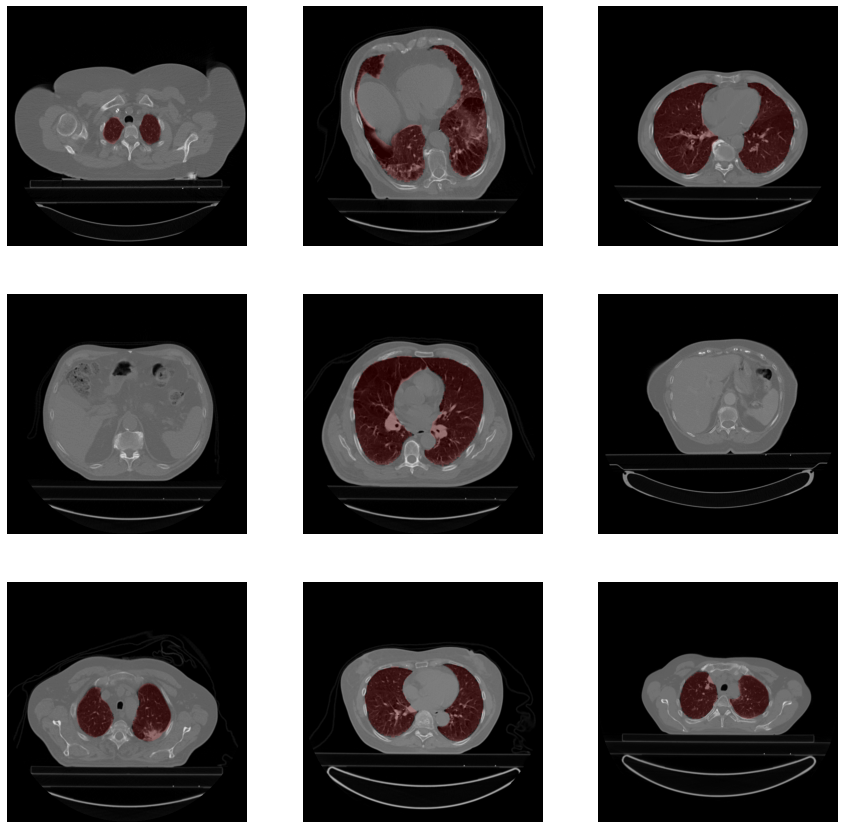

In [7]:
itr = iter(val_loader)
for i in range(6):
    next(itr)
X_batch, y_batch = next(itr)
plot_samples(X_batch, y_batch)

In [41]:
ct_img_slow, _ = get_data_pair("LUNG1-002");

dicom loading takes 0.37s


In [42]:
# try reading volume
from pydicom.filereader import read_dicomdir
t0 = time.time()
dcm_paths = glob.glob("data/raw/NSCLC-Radiomics/LUNG1-002/*/*/*/*.dcm")
dcm_files = [pydicom.read_file(path) for path in dcm_paths]
dcm_files = sorted(dcm_files, key=lambda s: s.SliceLocation) 
t1 = time.time()
img = [apply_modality_lut(dicom.pixel_array, dicom) for dicom in dcm_files]
img = np.array(img)
print(np.sum(np.abs(ct_img_slow - img)))

0.0


In [57]:
%%timeit
from pydicom.pixel_data_handlers.util import apply_modality_lut
dicom = pydicom.read_file("data/raw/NSCLC-Radiomics/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331/09-18-2008/1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046/1.3.6.1.4.1.32722.99.99.104776423223073991273677458347669148913.dcm")
#hu = apply_modality_lut(dicom.pixel_array, dicom).astype(np.float32)

2.06 ms ± 92.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
t0 = time.time()
masks = read_seg_masks("data/raw/Thoracic_Cavities/LUNG1-001/LUNG1-001_thor_cav_primary_reviewer.nii.gz")
t1 = time.time()
print(t1 - t0)

0.5434455871582031


In [83]:
from data import process_NSCLC_seg_masks
process_NSCLC_seg_masks()

CT scan: 100%|██████████| 402/402 [17:49<00:00,  2.66s/it]


In [77]:
seg_dir = "data/interim/NSCLC_ground_truths/LUNG1-001/"
masks = []
for slice_idx in range(134):
    masks.append(np.load(f"{seg_dir}/{slice_idx}.npy"))
masks = np.array(masks)
masks.shape

(134, 512, 512)

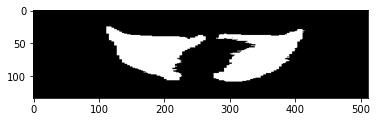

In [81]:
plt.imshow(masks[:,256,:], cmap='gray')